In [1]:
import numpy as np
import pandas as pd
import os
from bambi import Model

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import aggregate_subject_level

from glam.plots import plot_correlation, add_regression_line

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(9) # from random.org

# 4. GLAM parameters predict behavior

In [3]:
all_data = pd.read_csv('data/data_aggregate.csv')
even = all_data[(all_data['trial'] % 2) == 0].reset_index(drop=True)
odd = all_data[(all_data['trial'] % 2) == 1].reset_index(drop=True)

In [4]:
odd_summary = pd.DataFrame()

for di, dataset in enumerate(odd['dataset'].unique()):
    odd_di = odd[odd['dataset'] == dataset].copy()
    n_items = odd_di['n_items'].unique()[0]
    
    odd_summary_di = aggregate_subject_level(odd_di, n_items=n_items)
    
    odd_summary = pd.concat([odd_summary, odd_summary_di])

In [5]:
odd_summary.head()

rt                                                     \
                mean          std     min      max          se       q1   
subject                                                                   
0        1704.177778   881.852300   682.0   4142.0  132.944236  1125.00   
1        1728.489796   857.141479   743.0   4602.0  123.717716  1166.00   
2        4078.660000  2623.044800   943.0  12079.0  374.720686  2104.25   
3        1893.545455   633.499496  1045.0   4742.0   96.607767  1436.50   
4        1846.640000  1093.485579   692.0   5891.0  156.212226  1221.50   

                         best_chosen gaze_influence       dataset  
             q3      iqr        mean                               
subject                                                            
0        1970.0   845.00    0.822222      -0.020906  krajbich2010  
1        1937.0   771.00    0.673469       0.367354  krajbich2010  
2        5329.0  3224.75    0.840000       0.020812  krajbich2010  
3        2175.5   739.00    0.704545       0.018119  krajbich2010  
4        2132.5   911.00    0.840000       0.028416  krajbich2010

## load parameter estimates

In [6]:
estimates = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_df = pd.read_csv(os.path.join('results', 'estimates', 'out_of_sample', 'multiplicative',
                                                    'estimates_{}_multiplicative_oos.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_dict = {parameter: subject_estimates_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_dict['subject'] = subject
    estimates = pd.concat([estimates,
                           pd.DataFrame(subject_estimates_dict,
                                        index=np.ones(1)*subject)])

estimates.head()

,v,gamma,s,tau,subject
0.0,0.000098,0.65,0.008368,0.44,0
1.0,0.000096,0.05,0.013663,0.21,1
2.0,0.000022,0.80,0.009960,1.99,2
3.0,0.000090,0.25,0.005090,0.07,3
4.0,0.000091,0.16,0.008927,0.32,4


# Mixed effects regressions with random slope and intercept for data sets

In [7]:
# Format data for mixed model
df = pd.concat([estimates, odd_summary], axis=1)
df['log_rt'] = np.log(df[('rt', 'mean')])
df['log_v'] = np.log(df['v'])
df['best_chosen'] = 100 * df[('best_chosen', 'mean')]
df['gaze_influence'] = 100 * df[('gaze_influence', '')]
df['dataset'] = df[('dataset', '')]

df = df[['subject', 'dataset', 'log_rt', 'best_chosen', 'gaze_influence', 'log_v', 'gamma', 's', 'tau']].copy().reset_index(drop=True)

In [8]:
df.head()

,subject,dataset,log_rt,best_chosen,gaze_influence,log_v,gamma,s,tau
0,0,krajbich2010,7.440838,82.222222,-2.090642,-9.230543,0.65,0.008368,0.44
1,1,krajbich2010,7.455003,67.346939,36.735420,-9.251162,0.05,0.013663,0.21
2,2,krajbich2010,8.313524,84.000000,2.081197,-10.724468,0.80,0.009960,1.99
3,3,krajbich2010,7.546206,70.454545,1.811876,-9.315701,0.25,0.005090,0.07
4,4,krajbich2010,7.521123,84.000000,2.841602,-9.304651,0.16,0.008927,0.32


In [9]:
n_samples = 20000

In [10]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_a_v_rt.csv')

if not os.path.isfile(result_file):

    model_a = Model(df)
    result_a = model_a.fit('log_rt ~ log_v',
                           random=['log_v|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)

    summary_a = result_a.summary(ranefs=True)
    summary_a.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_a = pd.read_csv(result_file, index_col=0)
summary_a

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_a_v_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-0.030420,0.318829,-1.022188e+00,0.467652,35,1.058238
1|dataset[krajbich2010],0.150108,0.320668,-2.006375e-01,1.002271,48,1.004596
1|dataset[krajbich2011],-0.141485,0.307493,-1.071631e+00,0.277225,35,1.053044
1|dataset[tavares2017],-0.097221,0.285454,-7.600558e-01,0.522829,87,1.024860
Intercept,0.063642,0.331761,-5.145824e-01,0.721924,50,1.040234
log_v,-0.781487,0.044930,-8.397959e-01,-0.643229,28,1.036356
1|dataset_sd,0.315169,0.371298,1.576676e-05,1.251907,39,1.028089
log_v|dataset[folke2016],-0.019761,0.042868,-1.760845e-01,0.018717,22,1.049736
log_v|dataset[krajbich2010],0.008597,0.022512,-2.903485e-02,0.063341,643,1.000778
log_v|dataset[krajbich2011],-0.016111,0.042784,-1.525679e-01,0.025509,23,1.043938


In [11]:
from pymc3 import plot_posterior

result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_b_gamma_best_chosen.csv')

if not os.path.isfile(result_file):
    model_b = Model(df)
    result_b = model_b.fit('best_chosen ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    plot_posterior(model_b.backend.trace, varnames=['gamma'], ref_val=0, color='lightblue', point_estimate='mode');
    plt.savefig(os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_b_gamma_best_chosen_posteriorplot.png'))
    summary_b = result_b.summary(ranefs=True)
    summary_b.loc['gamma', 'P(>0)'] = np.mean(model_b.backend.trace.get_values('gamma') > 0)
    summary_b.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_b = pd.read_csv(result_file, index_col=0)
summary_b

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_b_gamma_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,P(>0)
1|dataset_sd,8.066150,2.665267,3.686953,13.452823,16908,1.000036,NaN
Intercept,76.614535,3.992460,68.578961,84.607305,7874,1.000194,NaN
gamma|dataset_sd,15.509638,7.313230,4.353149,30.445010,12113,1.000003,NaN
best_chosen_sd,7.552916,0.522154,6.550855,8.586439,35776,0.999979,NaN
gamma,12.439864,7.772006,-3.933989,27.860702,7072,1.000019,0.9418
gamma|dataset[folke2016],17.276215,9.280905,0.102348,36.759920,9376,1.000022,NaN
gamma|dataset[krajbich2010],-9.143330,7.943437,-24.853635,7.647589,7538,0.999991,NaN
gamma|dataset[krajbich2011],2.243600,8.108857,-13.531659,19.442112,7979,1.000043,NaN
gamma|dataset[tavares2017],-3.039422,8.829622,-21.164983,14.678772,10260,1.000017,NaN
1|dataset[folke2016],-8.294362,4.161885,-16.334209,0.402161,8929,1.000195,NaN


In [12]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_c_gamma_gaze_influence.csv')

if not os.path.isfile(result_file):
    model_c = Model(df)
    result_c = model_c.fit('gaze_influence ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_c = result_c.summary(ranefs=True)
    summary_c.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_c = pd.read_csv(result_file, index_col=0)
summary_c

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_c_gamma_gaze_influence.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
gamma,-23.675140,4.993298,-34.008541,-13.602039,7972,1.000281
gamma|dataset_sd,6.218885,5.974768,0.001145,17.964271,5993,1.000204
1|dataset[folke2016],1.635350,2.617824,-3.098249,7.445386,13249,1.000163
1|dataset[krajbich2010],0.435512,2.380840,-4.569347,5.636151,11114,1.000168
1|dataset[krajbich2011],0.327568,2.381813,-4.745267,5.426783,13037,0.999989
1|dataset[tavares2017],-2.269635,2.732433,-8.109108,2.454776,13203,1.000056
Intercept,26.398270,2.191812,21.635236,30.870483,10277,1.000104
gaze_influence_sd,12.085332,0.805259,10.532960,13.659938,32710,1.000070
1|dataset_sd,3.330268,2.650646,0.000036,8.427078,6939,1.000168
gamma|dataset[folke2016],0.241758,5.649956,-11.593406,12.866469,15807,0.999992


In [17]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_x_sigma_best_chosen.csv')

if not os.path.isfile(result_file):
    model_x = Model(df)
    result_x = model_x.fit('best_chosen ~ s',
                           random=['s|dataset'],
                           categorical=['dataset'],
                           samples=n_samples*2,
                           chains=2)
    summary_x = result_x.summary(ranefs=True)
    summary_x.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_x = pd.read_csv(result_file, index_col=0)
summary_x

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 455.52:  21%|██        | 10518/50000 [00:08<00:32, 1197.71it/s]
Convergence archived at 10600
Interrupted at 10,599 [21%]: Average Loss = 718.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [best_chosen_sd_interval__, s|dataset_offset, s|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, s, Intercept]
100%|██████████| 40500/40500 [38:20<00:00, 17.60it/s]
There were 478 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
s,-218.290933,687.866585,-1648.747810,1140.522696,972,1.000934
s|dataset[folke2016],-423.039128,922.112467,-2576.908701,1212.060747,7285,1.000000
s|dataset[krajbich2010],-22.683158,669.390483,-1403.399496,1488.248893,1833,1.000408
s|dataset[krajbich2011],-103.307688,654.083927,-1545.975352,1265.785356,2446,1.000340
s|dataset[tavares2017],461.986411,724.248806,-760.313402,2160.971207,2243,1.000421
best_chosen_sd,9.180180,0.619695,7.974797,10.391929,36172,0.999998
Intercept,78.021205,6.993709,63.444180,92.304093,3185,1.000998
1|dataset[folke2016],-8.238413,7.405846,-23.702327,5.760627,6003,1.000218
1|dataset[krajbich2010],5.189763,6.891942,-8.148111,20.474559,4042,1.000515
1|dataset[krajbich2011],-1.474676,6.719203,-16.090906,12.181631,4236,1.000479


# Figure 6

In [14]:
import matplotlib.patches as mpatches

def figure_6(estimates, summary, figsize=(7.5, 2.5), alpha=1.0, fontsize=8):
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    
    colors = np.array(['C{}'.format(i)
                       for i in range(summary['dataset'].unique().size)])
    color_idx = pd.Categorical(summary['dataset'],
                               categories=['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017'],
                               ordered=True).codes.astype(int)
    
    plot_correlation(np.log(estimates['v']),
                     np.log(summary['rt']['mean']),
                     marker='+',
                     alpha=alpha,
                     markercolor=colors[color_idx],
                     regression=False,
                     color='gray',
                     xlabel=r'Log $\hat{v}$',
                     ylabel='Log mean RT (ms)',
                     ax=axs[0])
    
    plot_correlation(estimates['gamma'],
                     summary['best_chosen']['mean'],
                     marker='+',
                     alpha=alpha,
                     markercolor=colors[color_idx],
                     regression=False,
                     color='gray',
                     xlabel=r'$\hat{\gamma}$',
                     ylabel='P(choose best)',
                     ax=axs[1])

    plot_correlation(estimates['gamma'],
                     summary['gaze_influence'],
                     marker='+',
                     alpha=alpha,
                     markercolor=colors[color_idx],
                     regression=False,
                     xlabel=r'$\hat{\gamma}$',
                     ylabel='Gaze influence on\nP(choice | value)',
                     ax=axs[2],
                     annotation_pos=(0.1, 0.9),
                     color='gray')
    
    patches = [mpatches.Patch(color=color, label=label)
               for color, label in zip(colors, ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'])]
    axs[0].legend(patches,
                  ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                  loc='lower left',
                  handlelength=1, handleheight=1,
                  fontsize=6, 
                  frameon=False)

    # Labels
    for label, ax in zip(list('abc'), axs.ravel()):
        ax.text(-0.2, 1.2, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=fontsize)
        
    fig.tight_layout(pad=1)
    
    return fig, axs

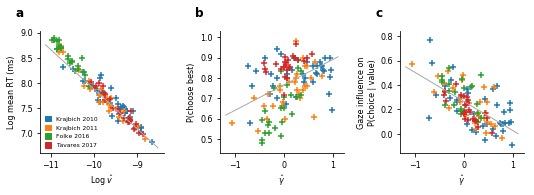

In [15]:
fig, axs = figure_6(estimates, odd_summary, figsize=(7.5, 2.5))

add_regression_line(axs[0], summary_a.loc['Intercept', 'mean'], summary_a.loc['log_v', 'mean'], linewidth=1)
add_regression_line(axs[1], summary_b.loc['Intercept', 'mean'] / 100, summary_b.loc['gamma', 'mean'] / 100, linewidth=1)
add_regression_line(axs[2], summary_c.loc['Intercept', 'mean'] / 100, summary_c.loc['gamma', 'mean'] / 100, linewidth=1)

plt.savefig('results/figures/figure_6_glam_parameters_predict_behavior.png', dpi=330, bbox_inches='tight')
plt.show()